# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
import os
import torch.optim as optim
from torchvision import transforms,models
from torchvision.transforms.functional import crop
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import cv2
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(f"Using device: {device}")

True
Using device: cuda


# Model architecture

In [2]:
class LaneDetectionCNN(nn.Module):
    def __init__(self, input_shape=(3, 224, 224)):
        super(LaneDetectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Calculate flat size dynamically
        self._to_linear = None
        self._calculate_flat_size(input_shape)

        self.fc1 = nn.Linear(self._to_linear, 7*7*3) # 7x7 image with 3 channels
        self.fc2 = nn.Linear(7*7*3, 1)  # Single output neuron for regression

    def _calculate_flat_size(self, input_shape):
        x = torch.zeros(1, *input_shape)
        x = self._forward_conv(x)
        self._to_linear = x.numel()

    def _forward_conv(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.maxpool1(x)
        x = torch.relu(self.conv3(x))
        x = self.maxpool2(x)
        x = torch.relu(self.conv4(x))
        x = self.maxpool3(x)
        x = torch.relu(self.conv5(x))
        x = self.maxpool4(x)
        x = self.dropout(x)
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1) 
        x = torch.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = x*0.5 #Scale output to be between -0.5 and 0.5
        return x

summary(LaneDetectionCNN().to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]           1,216
            Conv2d-2         [-1, 32, 112, 112]          12,832
         MaxPool2d-3           [-1, 32, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]          18,496
         MaxPool2d-5           [-1, 64, 28, 28]               0
            Conv2d-6          [-1, 128, 28, 28]          73,856
         MaxPool2d-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 256, 14, 14]         295,168
         MaxPool2d-9            [-1, 256, 7, 7]               0
          Dropout-10            [-1, 256, 7, 7]               0
           Linear-11                  [-1, 147]       1,844,115
           Linear-12                    [-1, 1]             148
Total params: 2,245,831
Trainable params: 2,245,831
Non-trainable params: 0
---------------------------

# Data related functions

In [3]:
class ImageDataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform
        self.image_files = sorted(os.listdir(image_folder))  # Ensure consistent order
        self.label_files = sorted(os.listdir(label_folder))  # Ensure consistent order

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Load corresponding label
        label_path = os.path.join(self.label_folder, self.label_files[idx])
        with open(label_path, "r") as f:
            label = float(f.read().strip())  # Read distance as float

        return image, torch.tensor([label], dtype=torch.float32)

# Prepare dataset, split into train, validation, and test sets
def prepare_dataset(image_folder, label_folder):
    # Preprocessing : Define transformations to apply to each image
    transform = transforms.Compose([
        #Crop only the top 2/3 of the image, removing the top 1/3
        transforms.Lambda(apply_preprocessing),
        transforms.Resize((224, 224)),  # Resize to 224x224
        transforms.GaussianBlur(3, sigma=(0.1, 2.0)),  # Apply Gaussian blur
        transforms.ToTensor(),  # Convert to tensor without resizing
    ])

    dataset = ImageDataset(image_folder, label_folder, transform=transform)

    train_dataset, val_test_set = random_split(dataset, [3000,1000]) # Lets start with 75-15-10 split
    val_dataset, test_dataset = random_split(val_test_set, [600,400])
    
    return train_dataset, val_dataset, test_dataset

def get_dataloaders(image_folder, label_folder, batch_size):
    """
    Create DataLoaders for the dataset.

    Parameters:
    - image_folder: Path to the folder containing images.
    - label_folder: Path to the folder containing labels.
    - batch_size: Batch size for the DataLoader.
    - input_shape: Tuple (height, width) for resizing images.

    Returns:
    - DataLoaders object for training, val and test.
    """
    train,val,test = prepare_dataset(image_folder, label_folder)
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)

    return train_dataloader,val_dataloader,test_dataloader


def get_input_shape(image_folder):
    """
    Dynamically determine the input shape from the first image in the dataset.

    Parameters:
    - image_folder: Path to the folder containing images.

    Returns:
    - Tuple representing the input shape (channels, height, width).
    """
    # Get the first image in the folder
    image_files = sorted(os.listdir(image_folder))
    if not image_files:
        raise ValueError(f"No images found in folder: {image_folder}")

    # Load the first image
    img_path = os.path.join(image_folder, image_files[0])
    with Image.open(img_path) as img:
        width, height = img.size  # Image dimensions
        
        channels = len(img.getbands())  # Number of color channels (e.g., RGB = 3)

    return (channels, 224, 224) #temporary for tests

def apply_preprocessing(image):
    """
    Apply preprocessing transformations to the input image.

    Parameters:
    - image: PIL Image object.
    """
    
    image_array = np.array(image)
    channels = [image_array[:, :, i] for i in range(image_array.shape[2])]
    h, w, _ = image_array.shape
    
    imghsv = cv2.cvtColor(image_array, cv2.COLOR_BGR2HSV)
    
    img = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)

    mask_ground = np.ones(img.shape, dtype=np.uint8)  # Start with a mask of ones (white)
    mid_point = img.shape[0] // 2  # Integer division to get the middle row index

    # Set the top half of the image to 0 (black)
    mask_ground[:mid_point-30, :] = 0  # Mask the top half (rows 0 to mid_point-1)
    
    #gaussian filter
    sigma = 3.5
    img_gaussian_filter = cv2.GaussianBlur(img,(0,0), sigma)
    
    sobelx = cv2.Sobel(img_gaussian_filter,cv2.CV_64F,1,0)
    sobely = cv2.Sobel(img_gaussian_filter,cv2.CV_64F,0,1)
    # Compute the magnitude of the gradients
    Gmag = np.sqrt(sobelx*sobelx + sobely*sobely)
    threshold = 35
    mask_mag = (Gmag > threshold)
        #4 Mask yellow and white

    white_lower_hsv = np.array([0,(0*255)/100,(60*255)/100]) # [0,0,50] - [230,100,255]
    white_upper_hsv = np.array([150,(40*255)/100,(100*255)/100])   # CHANGE ME

    yellow_lower_hsv = np.array([(30*179)/360, (30*255)/100, (30*255)/100])        # CHANGE ME
    yellow_upper_hsv = np.array([(90*179)/360, (110*255)/100, (100*255)/100])  # CHANGE ME
    mask_white = cv2.inRange(imghsv, white_lower_hsv, white_upper_hsv)
    mask_yellow = cv2.inRange(imghsv, yellow_lower_hsv, yellow_upper_hsv)

    mask_sobelx_pos = (sobelx > 0)
    mask_sobelx_neg = (sobelx < 0)
    mask_sobely_pos = (sobely > 0)
    mask_sobely_neg = (sobely < 0)

    final_mask = mask_ground * mask_mag  * (mask_white + mask_yellow) #* (mask_sobelx_neg * mask_sobely_neg + mask_sobelx_pos* mask_sobely_pos)
    # Convert the NumPy array back to a PIL image
    for channel in channels:
        channel *= final_mask
    filtered_image = np.stack(channels, axis=-1)
    filtered_image = Image.fromarray(filtered_image)
    return filtered_image

def apply_preprocessing2(image):
    """
    Apply preprocessing transformations to the input image.

    Parameters:
    - image: PIL Image object.
    """
    
    # Crop the top 1/3 of the image
    height = image.size[1]
    crop_height = height // 3
    
    image = crop(image, crop_height,0, image.size[1], image.size[0])
    # Convert the NumPy array back to a PIL image
    return image

def temp(image):
    image_array = np.array(image)
    # Crop the top 1/3 of the image
    height = image.size[1]
    crop_height = height // 3
    #adding black mask on top 1/3
    cropped_image_array = image_array
    cropped_image_array[:crop_height, :, :] = 0  # Set the top 1/3 to black
    
    #cropped_image_array = image_array[crop_height:, :, :]  # Crop the top 1/3
    
    # Convert the NumPy array back to a PIL image
    cropped_image_pil = Image.fromarray(cropped_image_array)
    return cropped_image_pil

# Pre-processing 

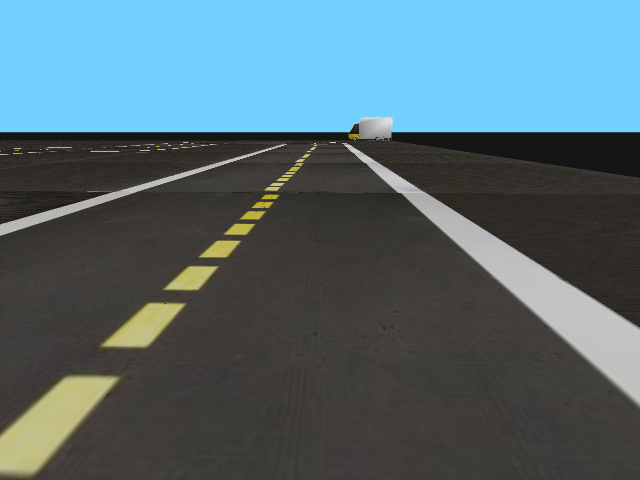

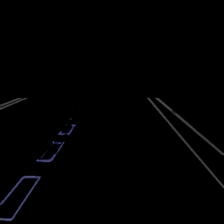

In [4]:
#Test preprocessing
# Read image 
image = Image.open('example.png') 
  
# create an transform for crop top 1/3 of the image
transform = transforms.Compose([
    transforms.Lambda(apply_preprocessing),
    transforms.Resize((224, 224))
])
#transform = transforms.CenterCrop(200) 
  
# use above created transform to crop  
# the image 
image_crop = transform(image) 
  
# display result 
display(image)
display(image_crop)

# Training and evaluation functions

In [5]:
# Training function
def train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=10):
    print("Start training")
    val_lossess = []
    train_lossess = []
    for epoch in range(n_epochs):
        total_loss = 0
        model.train(True)
        print(f"Epoch {epoch+1}/{n_epochs}")
        for i,data in enumerate(train_dataloader):
            Xbatch, ybatch = data
            # Move inputs and labels to device
            Xbatch, ybatch = Xbatch.to(device), ybatch.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(Xbatch)

            # Compute loss
            loss = loss_fn(y_pred, ybatch)
            
            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Track loss
            total_loss += loss.item()
            print(f"Batch {i+1}/{len(train_dataloader)} - Loss: {loss.item():.8f}", end="\r")
       
        print() # Newline
        train_loss = total_loss/len(train_dataloader)
        print(f"Training Loss: {total_loss/len(train_dataloader):.8f}")
        val_loss = evaluate_model(model, val_dataloader, loss_fn)
        print(f"Validation Loss: {val_loss:.8f}")
        val_lossess.append(val_loss)
        train_lossess.append(train_loss)

    return model, val_lossess, train_lossess

def evaluate_model(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for Xbatch, ybatch in dataloader:
            Xbatch, ybatch = Xbatch.to(device), ybatch.to(device)
            y_pred = model(Xbatch)
            loss = loss_fn(y_pred, ybatch)
            total_loss += loss.item()
    return total_loss/len(dataloader)

# Calling training functions (main)

Determined input shape: (3, 224, 224)
Number of images in the train dataset: 3000
Start training
Epoch 1/2
Batch 188/188 - Loss: 0.00448205
Training Loss: 0.00667217
Validation Loss: 0.00703533
Epoch 2/2
Batch 188/188 - Loss: 0.00157262
Training Loss: 0.00658189
Validation Loss: 0.00705991


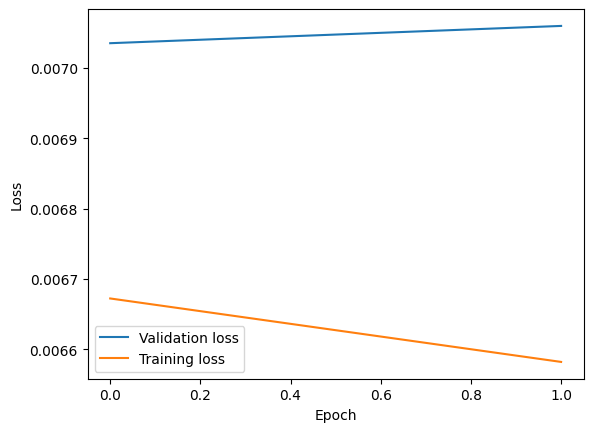

In [ ]:

IMAGE_FOLDER = "road_images/trail1/images"
LABEL_FOLDER = "road_images/trail1/labels"
LR = 0.001
NB_EPOCHS = 30
batch_size = 16

input_shape = get_input_shape(image_folder=IMAGE_FOLDER)
print(f"Determined input shape: {input_shape}")

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(IMAGE_FOLDER, LABEL_FOLDER, batch_size)
    
num_images = len(train_dataloader.dataset)
print(f"Number of images in the train dataset: {num_images}")


model = LaneDetectionCNN(input_shape).to(device)

loss_fn = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=LR)

# Train the model
model, val_losses, train_losses = train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=NB_EPOCHS)

# Plot val and train losses
import matplotlib.pyplot as plt
plt.plot(val_losses, label='Validation loss')
plt.plot(train_losses, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate model on test dataset

In [170]:
test_loss = evaluate_model(model, test_dataloader,loss_fn)
print(f"Test Loss: {test_loss:.8f}")

# Test Loss: 0.00017259


Test Loss: 0.00699789


# Saving the model

In [6]:
#Save the model
torch.save(model.state_dict(), "lane_detection_modelt.pth")
print("Model weights saved to 'lane_detection_model.pth'")

Model weights saved to 'lane_detection_model.pth'


# Loading model

In [4]:
# Initialize the model architecture
model = LaneDetectionCNN((3, 480, 640))

# Load the model weights
model.load_state_dict(torch.load("lane_detection_model.pth"))
model.eval()  # Set to evaluation mode
print("Model weights loaded from 'lane_detection_model.pth'")

Model weights loaded from 'lane_detection_model.pth'


/tmp/ipykernel_191433/563164654.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lane_detection_model.pth"))


# See an image from dataset

In [ ]:
for Xbatch, ybatch in train_dataloader:
    sample = Xbatch[0]
    image_array = (sample.permute(1, 2, 0).numpy() * 255).astype("uint8")
    print(type(image_array))  
    image_bgr = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)

    cv2.imshow("Image", image_bgr)
    cv2.waitKey(0)  # Wait for a key press
    cv2.destroyAllWindows()
    break
    

<class 'numpy.ndarray'>


# Testing predictions on random images

In [171]:
import random

def test_model_predictions(model, dataloader, device):
    """
    Test the trained model on a random image from the dataset.

    Parameters:
    - model: The trained neural network model.
    - dataloader: The DataLoader providing the test data.
    - device: The device to use for prediction ('cpu' or 'cuda').

    Returns:
    - Tuple containing the predicted distance and the actual label.
    """
    model.to(device)
    model.eval()  # Set model to evaluation mode

    # Choose a random batch and image
    random_idx = random.randint(0, len(dataloader.dataset) - 1)
    image_tensor, label_tensor = dataloader.dataset[random_idx]

    # Move image tensor and label to device
    image_tensor = image_tensor.to(device).unsqueeze(0)  # Add batch dimension
    # preprocess the image

    label_tensor = label_tensor.to(device)
    
    with torch.no_grad():
        prediction = model(image_tensor)  # Predict the distance
    predicted_distance = prediction.item()
    actual_label = label_tensor.item()

    print(f"Random Image Test:")
    print(f"  Predicted Distance: {predicted_distance}")
    print(f"  Actual Distance: {actual_label}")

    image_array = (image_tensor[0].cpu().permute(1, 2, 0).numpy() * 255).astype("uint8")
    image_bgr = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)

    cv2.imshow("Image", image_bgr)
    cv2.waitKey(0)  # Wait for a key press
    cv2.destroyAllWindows()

    return predicted_distance, actual_label

for _ in range(10):
    predicted_distance, actual_label = test_model_predictions(model, test_dataloader, device)


Random Image Test:
  Predicted Distance: 0.0026360282208770514
  Actual Distance: -0.002366388449445367
Random Image Test:
  Predicted Distance: 0.0026360282208770514
  Actual Distance: -0.06179431453347206
Random Image Test:
  Predicted Distance: 0.0026360282208770514
  Actual Distance: 0.038282256573438644
Random Image Test:
  Predicted Distance: 0.0026360282208770514
  Actual Distance: 0.038282256573438644
Random Image Test:
  Predicted Distance: 0.0026360282208770514
  Actual Distance: 0.01539981085807085
Random Image Test:
  Predicted Distance: 0.0026360282208770514
  Actual Distance: -0.0985298678278923
Random Image Test:
  Predicted Distance: 0.0026360282208770514
  Actual Distance: 0.017652001231908798
Random Image Test:
  Predicted Distance: 0.0026360282208770514
  Actual Distance: 0.008008991368114948
Random Image Test:
  Predicted Distance: 0.0026360282208770514
  Actual Distance: 0.050814852118492126
Random Image Test:
  Predicted Distance: 0.0026360282208770514
  Actual Di

# Testing on real images

In [ ]:
image = Image.open('pic2_rect.png') 
  
# need preprocessing
transform = transforms.Compose([
    transforms.Lambda(apply_preprocessing),
    transforms.Resize((224, 224)),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    transforms.ToTensor()  # Convert to tensor without resizing
])

image_tensor = transform(image)
image_tensor = image_tensor.to(device).unsqueeze(0)  # Add batch dimension

y_pred = model(image_tensor)
print(y_pred.item())

0.021392082795500755
